In [27]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML
import warnings
# warnings.filterwarnings('ignore')

In [28]:
def extracting(df):
    # Khởi tạo Label Encoder
    le = LabelEncoder()
    df['author'] = le.fit_transform(df['author'])
    df['language'] = le.fit_transform(df['language'])
    df['publisher'] = le.fit_transform(df['publisher'])
    df['page_format'] = le.fit_transform(df['page_format'])

    df.drop(['link', 'title'], axis=1, inplace=True)

    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
    df['genres'] = df['genres'].apply(lambda x: sorted(x))
    df['genres'] = df['genres'].apply(lambda x: ','.join(x))
    df['genres'] = le.fit_transform(df['genres'])

    df['ratings_count'] = df['ratings_count'].apply(lambda x: int(x.replace(',', '')))
    df['reviews_count'] = df['reviews_count'].apply(lambda x: int(x.replace(',', '')))
    df['num_pages'] = df['num_pages'].astype(float)
    df['publish_year'] = df['publish_year'].astype(float)
    
    return df

In [29]:
def fillMissingData(data_train, data_val, data_test):
    eod_columns = ['publish_year', 'num_pages']
    eod_values = [data_train[col].mean() + 3*data_train[col].std() for col in eod_columns]
    for col, val in zip(eod_columns, eod_values):
        data_train[col].fillna(val, inplace=True)
        data_val[col].fillna(val, inplace=True)
        data_test[col].fillna(val, inplace=True)
    return data_train, data_val, data_test

In [31]:
def plotDistribution(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    axes = axes.flatten()
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=50)
        ax.set_title(col)
    plt.show()

def plotCorrelation(data, columns):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(data[columns].corr())
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.show()

def plotScatter(data, columns, target):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.scatter(data[col], data[target])
        ax.set_title(col)
    plt.show()

def plotBar(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.bar(data[col].value_counts().index, data[col].value_counts())
        ax.set_title(col)
    plt.show()

def plotPie(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
        ax.set_title(col)
    plt.show()

def plotHeatmap(data, columns):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(data[columns].corr())
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.show()

def plotHistogram(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=30)
        ax.set_title(col)
    plt.show()

def plotCount(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.bar(data[col].value_counts().index, data[col].value_counts())
        ax.set_title(col)
    plt.show()

def plotBox(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.boxplot(data[col])
        ax.set_title(col)
    plt.show()

In [32]:
def printDescription(data, columns):
    for col in columns:
        print(data[col].describe())

In [33]:
skewedDists = ['ratings_count', 'reviews_count', 'num_pages', 'language']
isUpper_bridge = [True, True, True, True]
skewedDists = {col: isUpper_bridge for col, isUpper_bridge in zip(skewedDists, isUpper_bridge)}
gaussionDists = ['publish_year']
isUpper_boundary = [False]
gaussionDists = {col: isUpper_boundary for col, isUpper_boundary in zip(gaussionDists, isUpper_boundary)}

In [34]:
def outliers_handle(data, variable, isShow=False):
    upper_boundary=data[variable].mean() + 3 * data[variable].std()
    lower_boundary=data[variable].mean() - 3 * data[variable].std()
    if isShow:
        print(f"upper_boundary: {upper_boundary}")
        print(f"lower_boundary: {lower_boundary}")
        print(f"mean: {data[variable].mean()}")
    return lower_boundary, upper_boundary

def outliers_handle_skewed(data, variable, isShow=False):
    IQR=data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_bridge=data[variable].quantile(0.25) - (IQR*3)
    upper_bridge=data[variable].quantile(0.75) + (IQR*3)
    if isShow:
        print(f"lower_bridge: {lower_bridge}")
        print(f"upper_bridge: {upper_bridge}")
    return lower_bridge, upper_bridge

In [35]:
minMaxScaler = MinMaxScaler()
maxAbsScaler = MaxAbsScaler()
standardScaler = StandardScaler()
robustScaler = RobustScaler()
normalizer = Normalizer()
quantileTransformer = QuantileTransformer(n_quantiles=640)
powerTransformer = PowerTransformer()
scalerArr = [minMaxScaler, maxAbsScaler, standardScaler, robustScaler, normalizer, quantileTransformer, powerTransformer]

In [36]:
def scaleData(data_train, data_val, data_test, scaler):
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.copy()), columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.copy()), columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.copy()), columns=data_test.columns)
    return data_train, data_val, data_test

In [37]:
def handleOutlier(data_train, data_val, data_test):
    for col in skewedDists:
        lower_bridge, upper_bridge = outliers_handle_skewed(data_train, col)
        if skewedDists[col]:
            data_train.loc[data_train[col]>=upper_bridge,col]=upper_bridge
            data_val.loc[data_val[col]>=upper_bridge,col]=upper_bridge
            data_test.loc[data_test[col]>=upper_bridge,col]=upper_bridge
        else:
            data_train.loc[data_train[col]<=lower_bridge,col]=lower_bridge
            data_val.loc[data_val[col]<=lower_bridge,col]=lower_bridge
            data_test.loc[data_test[col]<=lower_bridge,col]=lower_bridge
        
    for col in gaussionDists:
        lower_boundary, upper_boundary = outliers_handle(data_train, col)
        if gaussionDists[col]:
            data_train.loc[data_train[col]>=upper_boundary,col]=upper_boundary
            data_val.loc[data_val[col]>=upper_boundary,col]=upper_boundary
            data_test.loc[data_test[col]>=upper_boundary,col]=upper_boundary
        else:
            data_train.loc[data_train[col]<=lower_boundary,col]=lower_boundary
            data_val.loc[data_val[col]<=lower_boundary,col]=lower_boundary
            data_test.loc[data_test[col]<=lower_boundary,col]=lower_boundary
    return data_train, data_val, data_test

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def featureSelection(X, y): 
    X_kbest = SelectKBest(f_classif, k = 5).fit(X, y)
    ix = X_kbest.get_support() 
    data = pd.DataFrame(X_kbest.transform(X), columns = X.columns.values[ix])
    # print(data.columns.values)
    return data.columns.values

In [53]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def featureSelection1(X, y):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=5, step=1)
    selector = selector.fit(X, y)
    ix = selector.get_support() 
    data = pd.DataFrame(selector.transform(X), columns = X.columns.values[ix])
    print(data.columns.values)
    return data.columns.values

In [54]:
def preprocessor(X_train, X_val, X_test):
    X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
    X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test)
    X_train, X_val, X_test = scaleData(X_train, X_val, X_test, powerTransformer)
    return X_train, X_val, X_test

In [55]:
def selectFeatures(X_train, y_train, X_val, X_test):
    featureArray = featureSelection1(X_train, y_train)
    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

In [56]:
def proccessing(file_path):
    df = pd.read_csv(file_path)

    # check for doublications
    print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
    if df.duplicated().any().sum() > 0:
        df.drop_duplicates(inplace=True)

    # check for missing values
    print(f"Number of missing values: \n{df.isnull().sum()}")

    df = extracting(df)

    data = df.copy()
    y = data['avg_ratings']
    X = data.drop(['avg_ratings'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train, X_val, X_test = preprocessor(X_train, X_val, X_test)
    X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test,X_train_SF, X_val_SF, X_test_SF

In [57]:
X_train, X_val, X_test, y_train, y_val, y_test,X_train_SF, X_val_SF, X_test_SF  = proccessing('data_10000.csv')

Number of duplicated rows: 1
Number of missing values: 
title              0
author             0
language         211
avg_ratings        0
ratings_count      0
reviews_count      0
publisher        372
publish_year      61
num_pages        124
page_format       44
genres             0
link               0
dtype: int64
['ratings_count' 'reviews_count' 'num_pages' 'page_format' 'genres']


# **MODEL**

Thư viện sử để sử dụng model

In [58]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
#lựa chọn siêu tham số
from sklearn.model_selection import GridSearchCV
#Metric đánh giá mô hình
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

Lấy X_train, y_train

In [59]:
X_train_SF.head()

,ratings_count,reviews_count,num_pages,page_format,genres
0,0.403950,0.692743,-0.071480,2.508845,1.201077
1,0.138715,0.027054,-0.060487,0.688504,0.728739
2,0.361205,0.242546,-1.323114,0.688504,1.238744
3,-0.574367,-0.957856,0.015445,-1.125764,-1.334117
4,0.698340,1.499411,0.052767,-1.125764,0.693191


In [127]:
# X_train_SF.head()

,language,ratings_count,reviews_count,publish_year,num_pages
0,0.098921,0.403950,0.692743,8.326673e-17,-0.071480
1,0.098921,0.138715,0.027054,-2.775558e-17,-0.060487
2,0.098921,0.361205,0.242546,-8.326673e-17,-1.323114
3,0.098921,-0.574367,-0.957856,0.000000e+00,0.015445
4,0.098921,0.698340,1.499411,1.387779e-16,0.052767


In [60]:
X_train_rf = X_train.copy()
X_train_svm = X_train.copy()
X_train_best_rf = X_train.copy()
X_train_best_svm = X_train.copy()

# X_train_SF_rf = X_train_SF.copy()
# X_train__SF_svm = X_train_SF.copy()

In [18]:
y_train

7003    3.89
4062    4.06
4239    3.76
9463    4.36
4142    3.57
        ... 
3557    4.00
5061    4.31
4459    4.04
2838    4.11
7350    3.87
Name: avg_ratings, Length: 6398, dtype: float64

In [19]:
X_test

,language,ratings_count,reviews_count,publish_year,num_pages
0,0.098921,0.022665,-0.252145,-2.775558e-17,0.522965
1,0.098921,0.231314,-0.125174,-5.551115e-17,-0.311538
2,0.098921,0.514512,0.519372,2.775558e-17,-0.110251
3,0.098921,0.036732,-0.239656,0.000000e+00,0.177669
4,0.098921,0.470144,0.869776,8.326673e-17,-0.546210
...,...,...,...,...,...
1995,0.098921,-0.229128,-0.385917,-8.326673e-17,0.443265
1996,0.098921,-0.284220,0.169860,5.551115e-17,-0.546210
1997,0.098921,-0.669776,-0.204596,-2.775558e-17,1.343737
1998,0.098921,0.998211,0.775572,0.000000e+00,0.052767


In [20]:
y_test

4122    4.16
4065    3.86
1731    4.28
4740    4.10
6391    4.05
        ... 
3799    3.78
8283    4.29
7851    4.04
1095    4.08
6927    4.31
Name: avg_ratings, Length: 2000, dtype: float64

# Random Forest Model

In [ ]:
# def model(mod, X_train, y_train, X_Pre):
#     mod.fit(X_train, y_train)
#     y_pred = mod.predict(X_Pre)
#     accuracyScore(ytest,y_pred)
    



Khi chưa select đặc trưng

In [65]:
#khởi tạo mô hình
#random_state=42
rf = RandomForestRegressor()

#chưa chọn đặc trưng
rf.fit(X_train_SF.copy(), y_train)
y_pred_rf_val = rf.predict(X_val_SF)

In [62]:
def plot_residuals(y_test, y_pred):
  ind = list(range(1, 201))
  fig, axs = plt.subplots(1, 1, figsize=(20, 6), sharey=True)
  axs.plot(ind, y_pred[:200], label='predicted value', color='blue')
  axs.plot(ind, y_test[:200], label='true_value', color='green')
  axs.legend()
  axs.set_ylabel('Rating')
  fig.suptitle('Predicted Value - True Value')
  plt.show()

Đánh giá mô hình

Ý nghĩa các metric:
- MAE (Mean Absolute Error) : Thể hiện sự chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- RMSE (Root Mean Squared Error) : Thể hiện độ lệch chuẩn giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- R2 score (Coefficient of Determination) : Thể hiện độ giải thích của mô hình trên tổng phương sai của dữ liệu. Giá trị này càng gần 1 thì mô hình càng tốt.
- MAPE (Mean Absolute Percentage Error)  : Thể hiện tỷ lệ chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.

In [63]:
def accuracyScore(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    # adjusted_r2 = 1 - (1-r2score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    print(
         f'MAE: \n{MAE}\n'
         f'RMSE: \n{RMSE}\n'
         f'R2 score: \n{r2score}\n'
         f'MAPE: \n{MAPE}\n')
    plt.scatter(y_test, y_pred, color='red')
    plt.xlabel('True values')
    plt.xlabel('Predicted values')
    plt.axis('equal')
    plt.axis('square')
    plt.show()
#     colors = np.random.choice(['g', 'orange'], size=1600)
#     plt.scatter(y_test, y_pred, c=colors)
#     plt.xlabel('True values')
#     plt.xlabel('Predicted values')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.show()

    # colors = np.random.choice(['g', 'orange'], size=1600)
    # plt.scatter(y_test, y_pred, c=colors)
    # plt.xlabel('True values')
    # plt.ylabel('Predicted values')
    # plt.show()

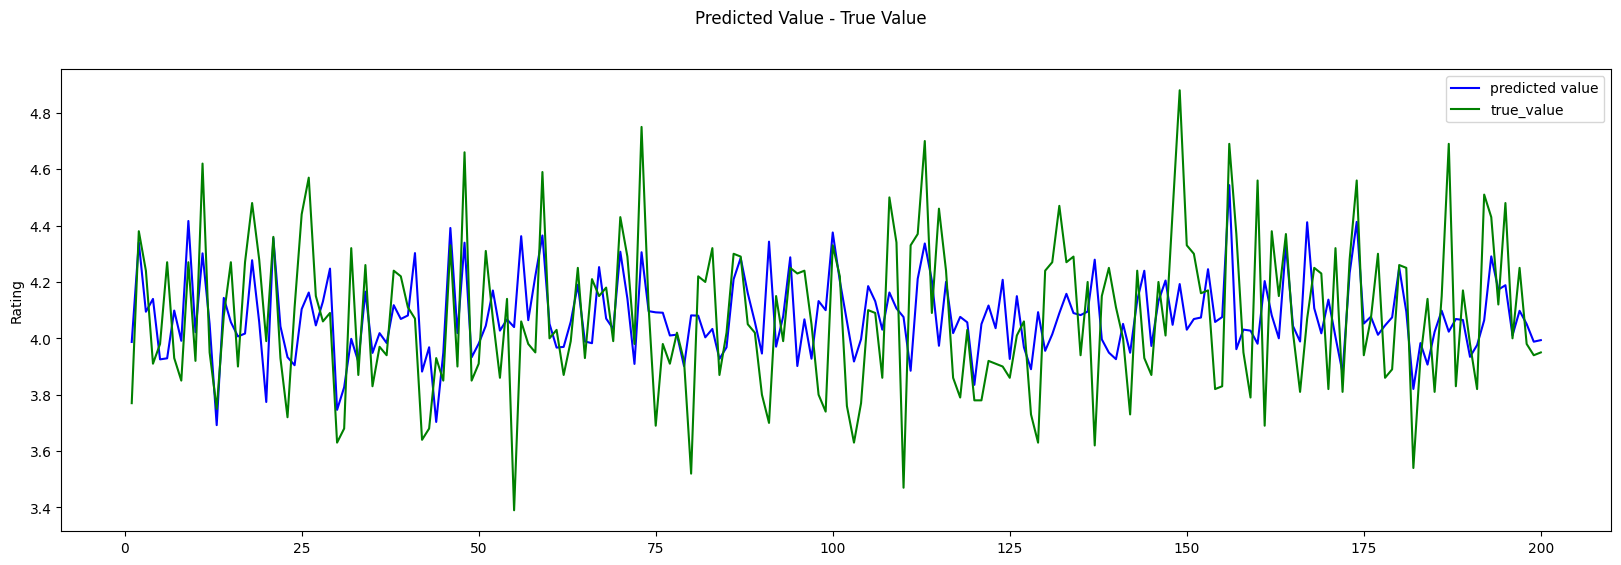

MAE: 
0.17608069270833338
RMSE: 
0.2317427149957597
R2 score: 
0.4968533531489602
MAPE: 
0.04371045290665391



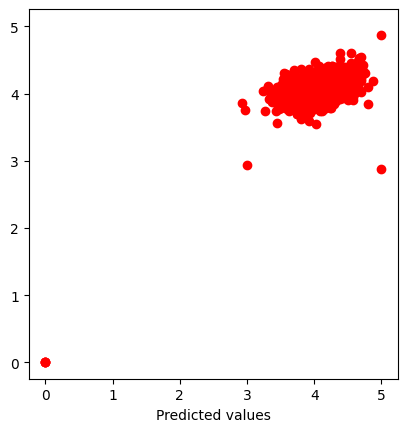

In [66]:
#chưa select
plot_residuals(y_val, y_pred_rf_val)
accuracyScore(y_val,y_pred_rf_val)

Define parameter grid for GridSearchCV

Ý nghĩa các tham số của mô hình rf
- n_estimators:  số lượng cây trong mô hình.
- max_depth:  độ sâu tối đa của các cây.
- min_samples_split:  số lượng mẫu tối thiểu để phân tách một nút.
- min_samples_leaf:  số lượng mẫu tối thiểu trong một lá cây.
- max_features:  số lượng tính năng tối đa được sử dụng để tìm kiếm trên mỗi nút.

In [140]:
#random forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 5, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [142]:
def findBestParams(model,param_grid, X_train, y_train):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    # Fit GridSearchCV on Validation set
    grid_search.fit(X_train, y_train)
    return grid_search

In [155]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
rf2 = RandomForestRegressor()
best_rf = findBestParams(rf2,param_grid_rf, X_train_rf, y_train).best_params_
best_rf

c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 500}

c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


MAE: 
0.1872027323029654
RMSE: 
0.2428683786154571
R2 score: 
0.44738286318207976
MAPE: 
485068954865.2612



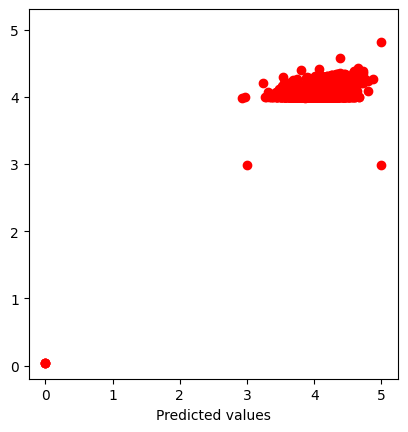

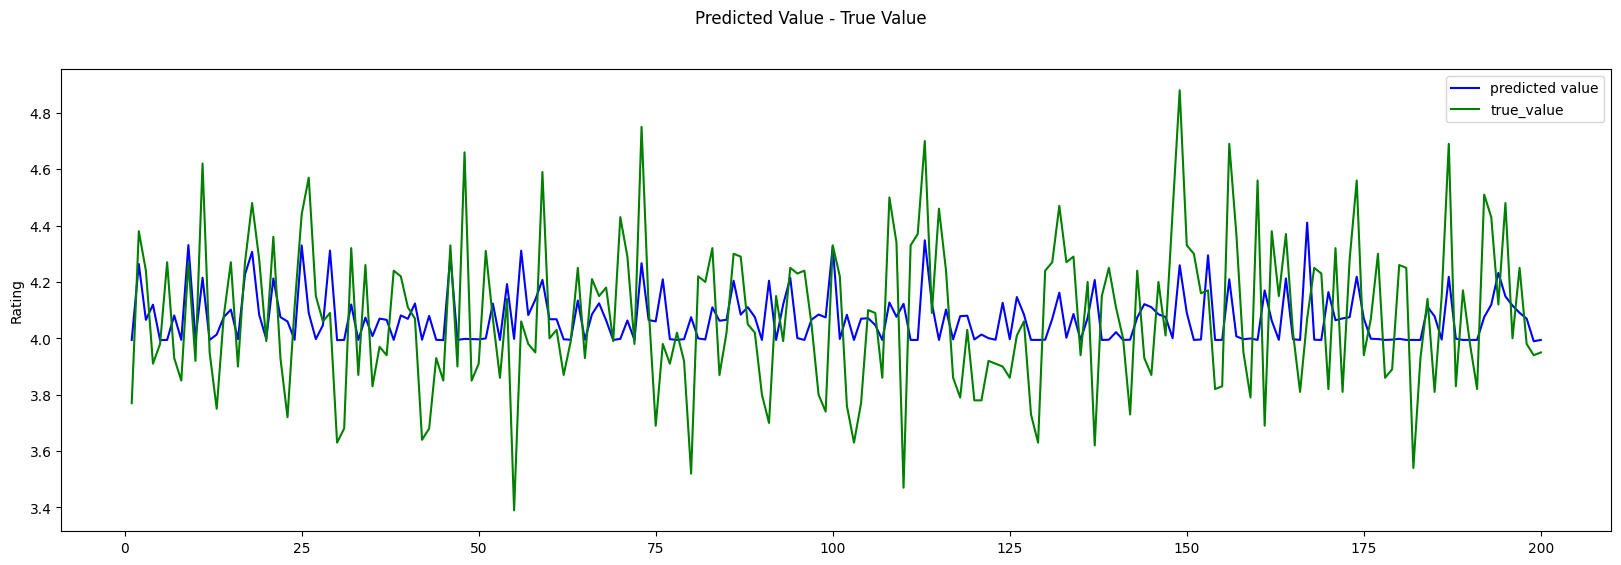

In [156]:

# Khởi tạo lại mô hình với các tham số tối ưu
rf_best_params = RandomForestRegressor(max_depth=best_rf['max_depth'], n_estimators=best_rf['n_estimators'], max_features=best_rf['max_features'], min_samples_split=best_rf['min_samples_split'], min_samples_leaf=best_rf['min_samples_leaf'], random_state=42 )

rf_best_params.fit(X_train_rf, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_rf = rf_best_params.predict(X_val)

accuracyScore(y_val, y_pred_best_rf)
plot_residuals(y_val, y_pred_best_rf)

MAE: 
0.19084394028203655
RMSE: 
0.24071673655909004
R2 score: 
0.291559218347755
MAPE: 
194015786804.25244



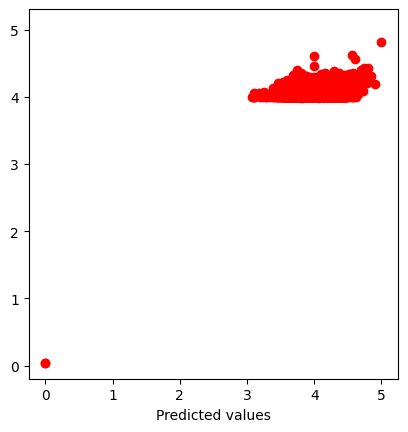

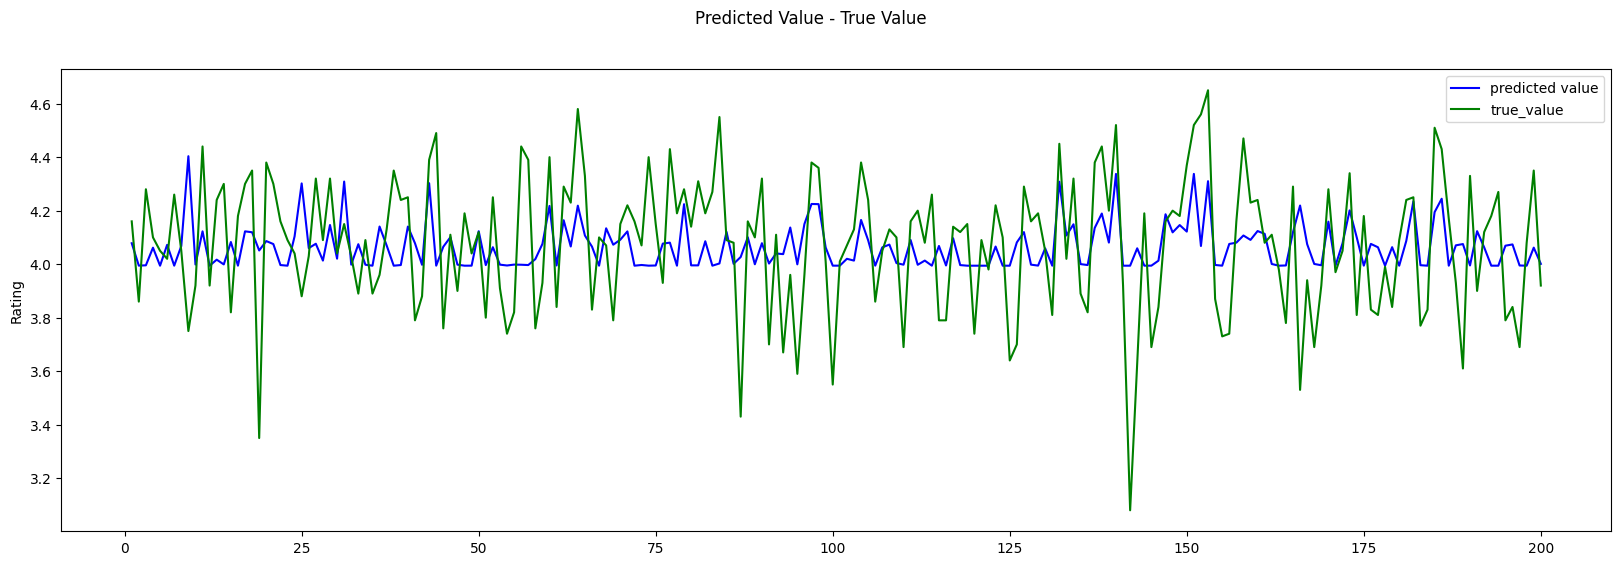

In [158]:
#Tập test
y_predTestRF = rf_best_params.predict(X_test)

accuracyScore(y_test, y_predTestRF)
plot_residuals(y_test, y_predTestRF)

# SVM MODEL

In [143]:
# Khởi tạo mô hình SVM
svr = SVR()
svr.fit(X_train_svm, y_train)
y_pred_svr_val = rf.predict(X_val)

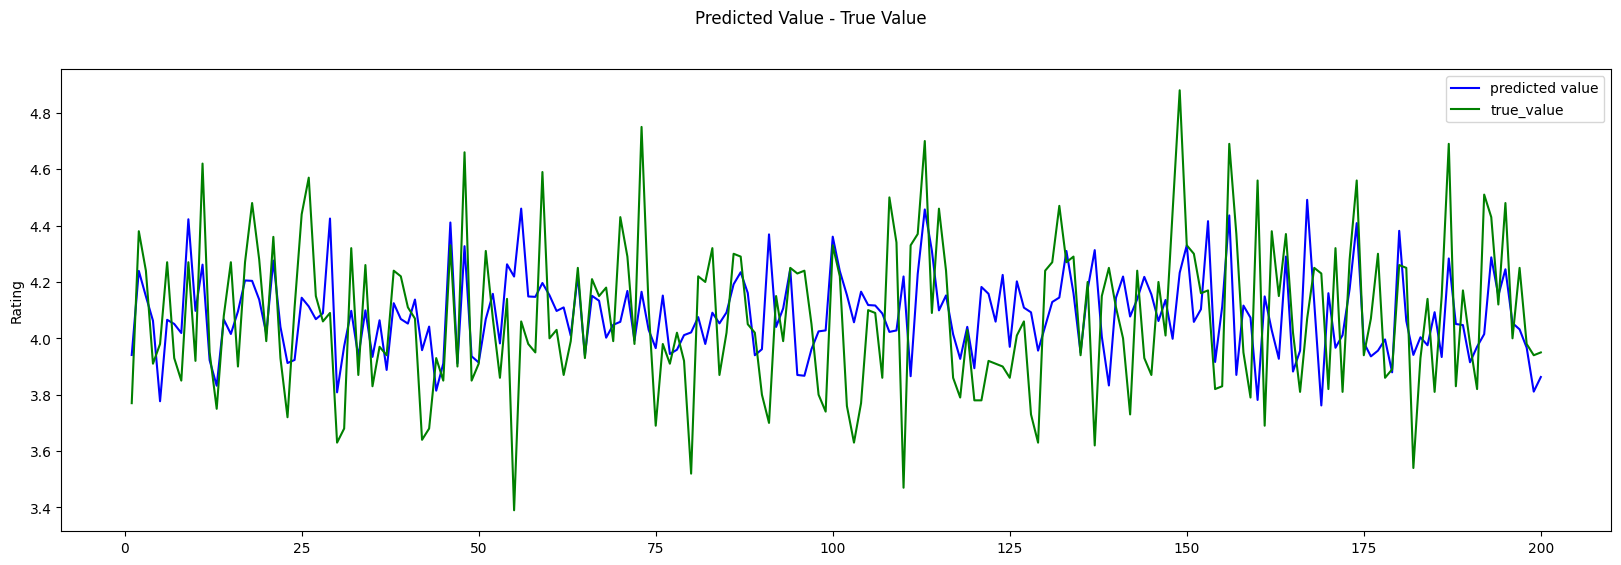

MAE: 
0.19146397139613852
RMSE: 
0.24966074361342827
R2 score: 
0.41604024073001755
MAPE: 
0.04751296441782041



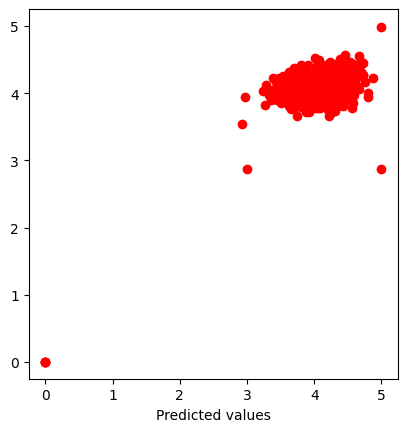

In [144]:
plot_residuals(y_val, y_pred_svr_val)
accuracyScore(y_val,y_pred_svr_val)

In [145]:
# Định nghĩa các tham số cần tinh chỉnh
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [147]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
svr2 = SVR()
best_svr = findBestParams(svr2,param_grid_svr, X_train_best_svm, y_train).best_params_
best_svr

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

MAE: 
0.19593474710161426
RMSE: 
0.321295320331389
R2 score: 
0.03285586696348286
MAPE: 
47411298377945.99



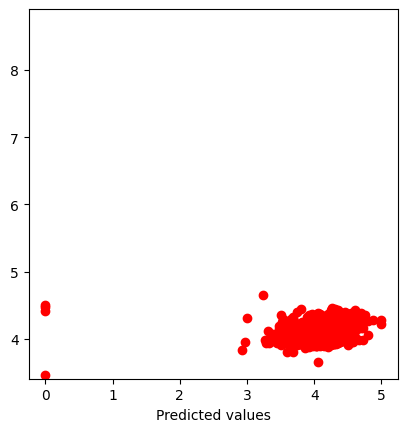

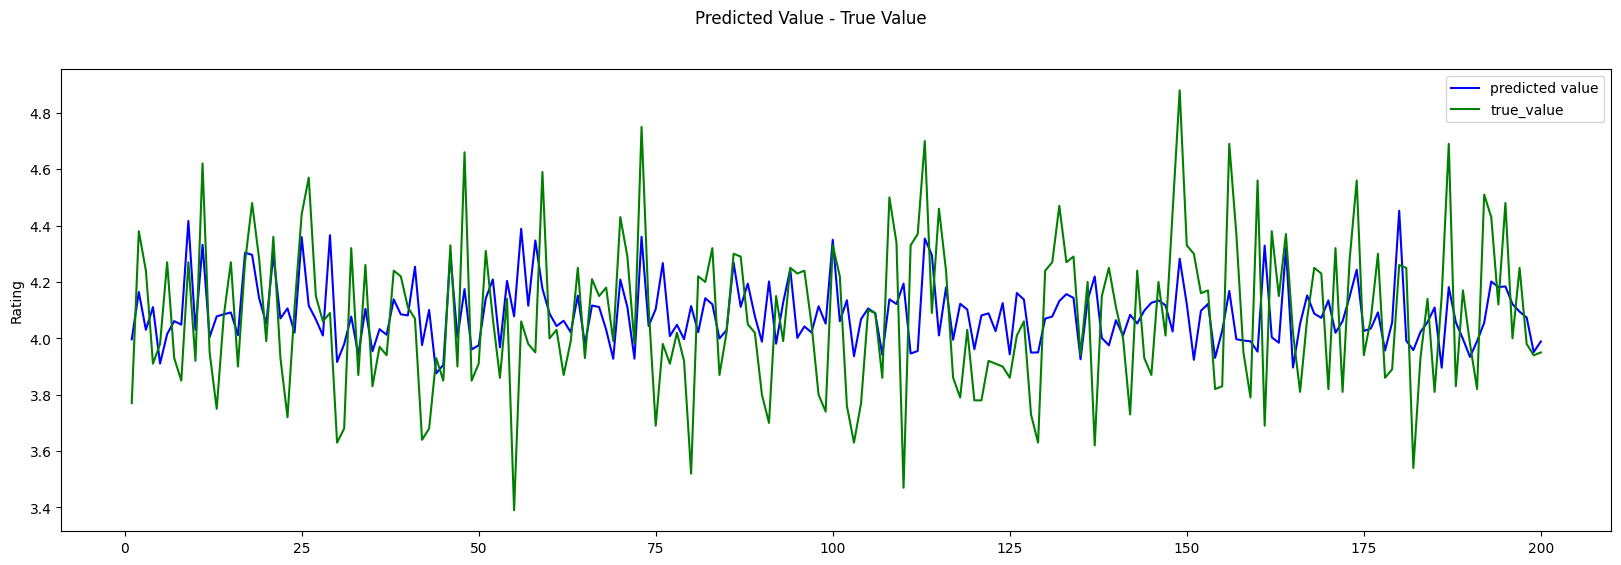

In [153]:
# Khởi tạo lại mô hình với các tham số tối ưu

svr_best_params = SVR(kernel=best_svr['kernel'], C=10, gamma=best_svr['gamma'], epsilon=0.1)

svr_best_params.fit(X_train_best_svm, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_svr = svr_best_params.predict(X_val)

accuracyScore(y_val, y_pred_best_svr)
plot_residuals(y_val, y_pred_best_svr)

MAE: 
0.19125538944876774
RMSE: 
0.2744191221358727
R2 score: 
0.07929665491439641
MAPE: 
19787650563339.04



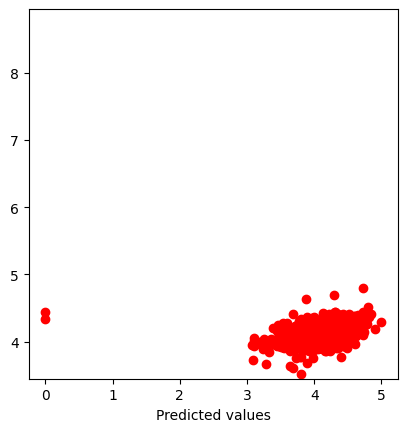

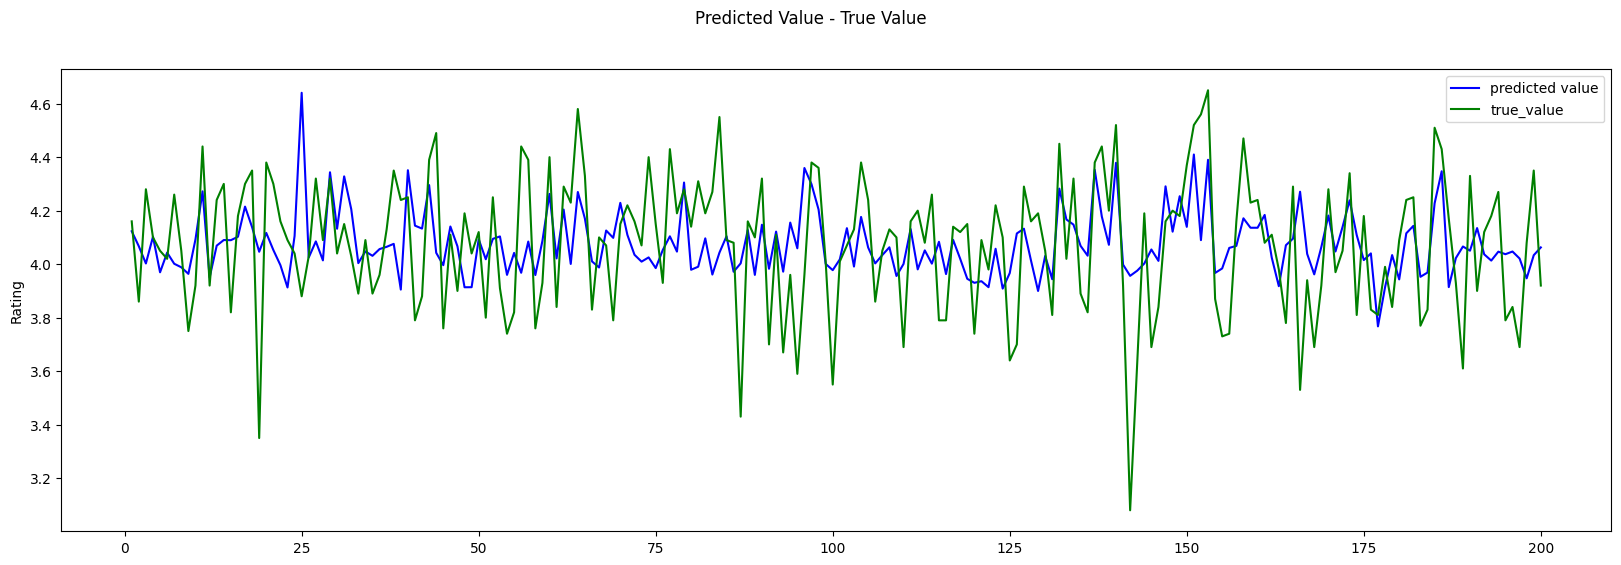

In [154]:
#Tập test
y_predTest = svr_best_params.predict(X_test)

accuracyScore(y_test, y_predTest)
plot_residuals(y_test, y_predTest)